# Analyze classifier evidence based on context decoding

In [1]:
import os
from pathlib import Path
import pingouin as pg
import seaborn as sns
from joblib import Parallel, delayed
import pandas as pd

from dcmr import task
from dcmr import decode
from dcmr import figures
from dcmr import framework
from psifr import fr

cfr_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS']) / 'switchboard4'

model_name = 'cmrsit_sem-split_cue-focused_dis-cat_sub-list'
model_label = 'DCMR-Disrupt'

sublayer = 'cat'
class_name = 'logreg_pmvpa_r10'

kind = 'context'
kind_label = 'Context'

fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim3'
fig_dir.mkdir(exist_ok=True)
figures.set_style()

In [2]:
data_file = cfr_dir / 'cfr_eeg_mixed.csv'
patterns_file = cfr_dir / 'cfr_patterns.hdf5'
eeg_class_dir = cfr_dir / 'eeg' / 'decode' / 'logreg_pmvpa_r10'
model_dir = fit_dir / model_name
out_dir = model_dir / f'decode_{sublayer}' / class_name
out_dir.mkdir(exist_ok=True, parents=True)
n_jobs = 8

In [3]:
_, subjects = task.get_subjects()
_ = Parallel(n_jobs=n_jobs)(
    delayed(decode._decode_context_subject)(
        data_file,
        patterns_file,
        model_dir,
        eeg_class_dir,
        sublayer,
        out_dir,
        subject,
        layers=['c'],
        weight=None,
        sigmas=None,
        n_reps=None,
        normalization='range',
        clf='plogreg',
        multi_class='auto',
        C=0.1,
    )
    for subject in subjects
)

In [4]:
data = framework.read_model_sims(data_file, fit_dir, [model_name], [model_label], block=True)

## Read classifier evidence

In [5]:
sigma = None
class_dir = fit_dir / model_name / f'decode_{sublayer}' / class_name
subjects, _ = task.get_subjects()
evidence = decode.read_evidence(class_dir, subjects)
if sigma is not None:
    evidence = evidence.query(f'include and sigma == {sigma}')

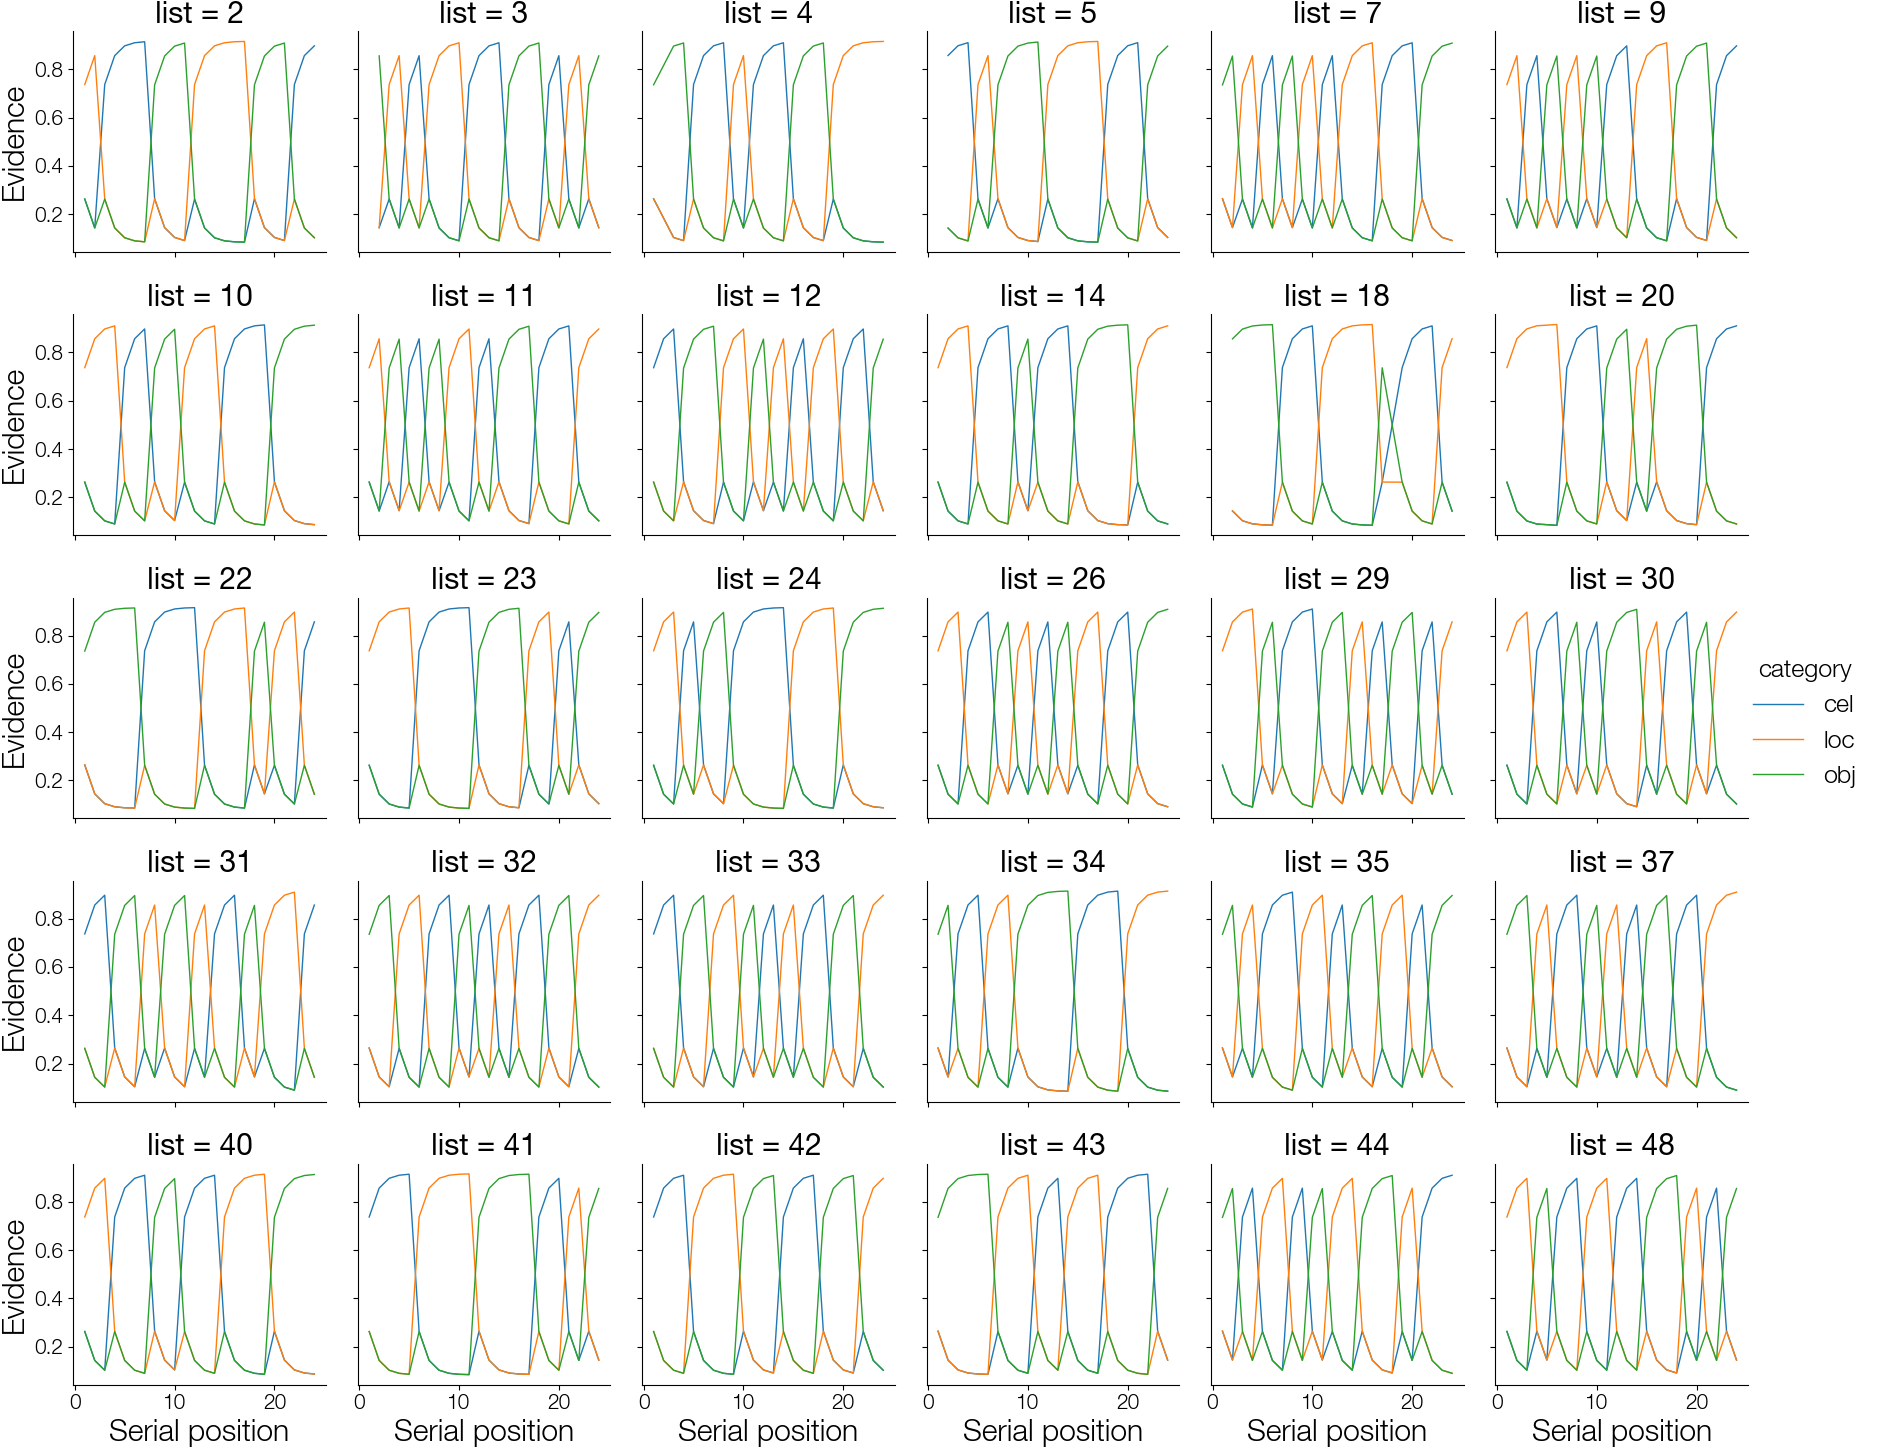

In [6]:
g = figures.plot_trial_evidence(evidence, 25)

## Classifier evidence by block position

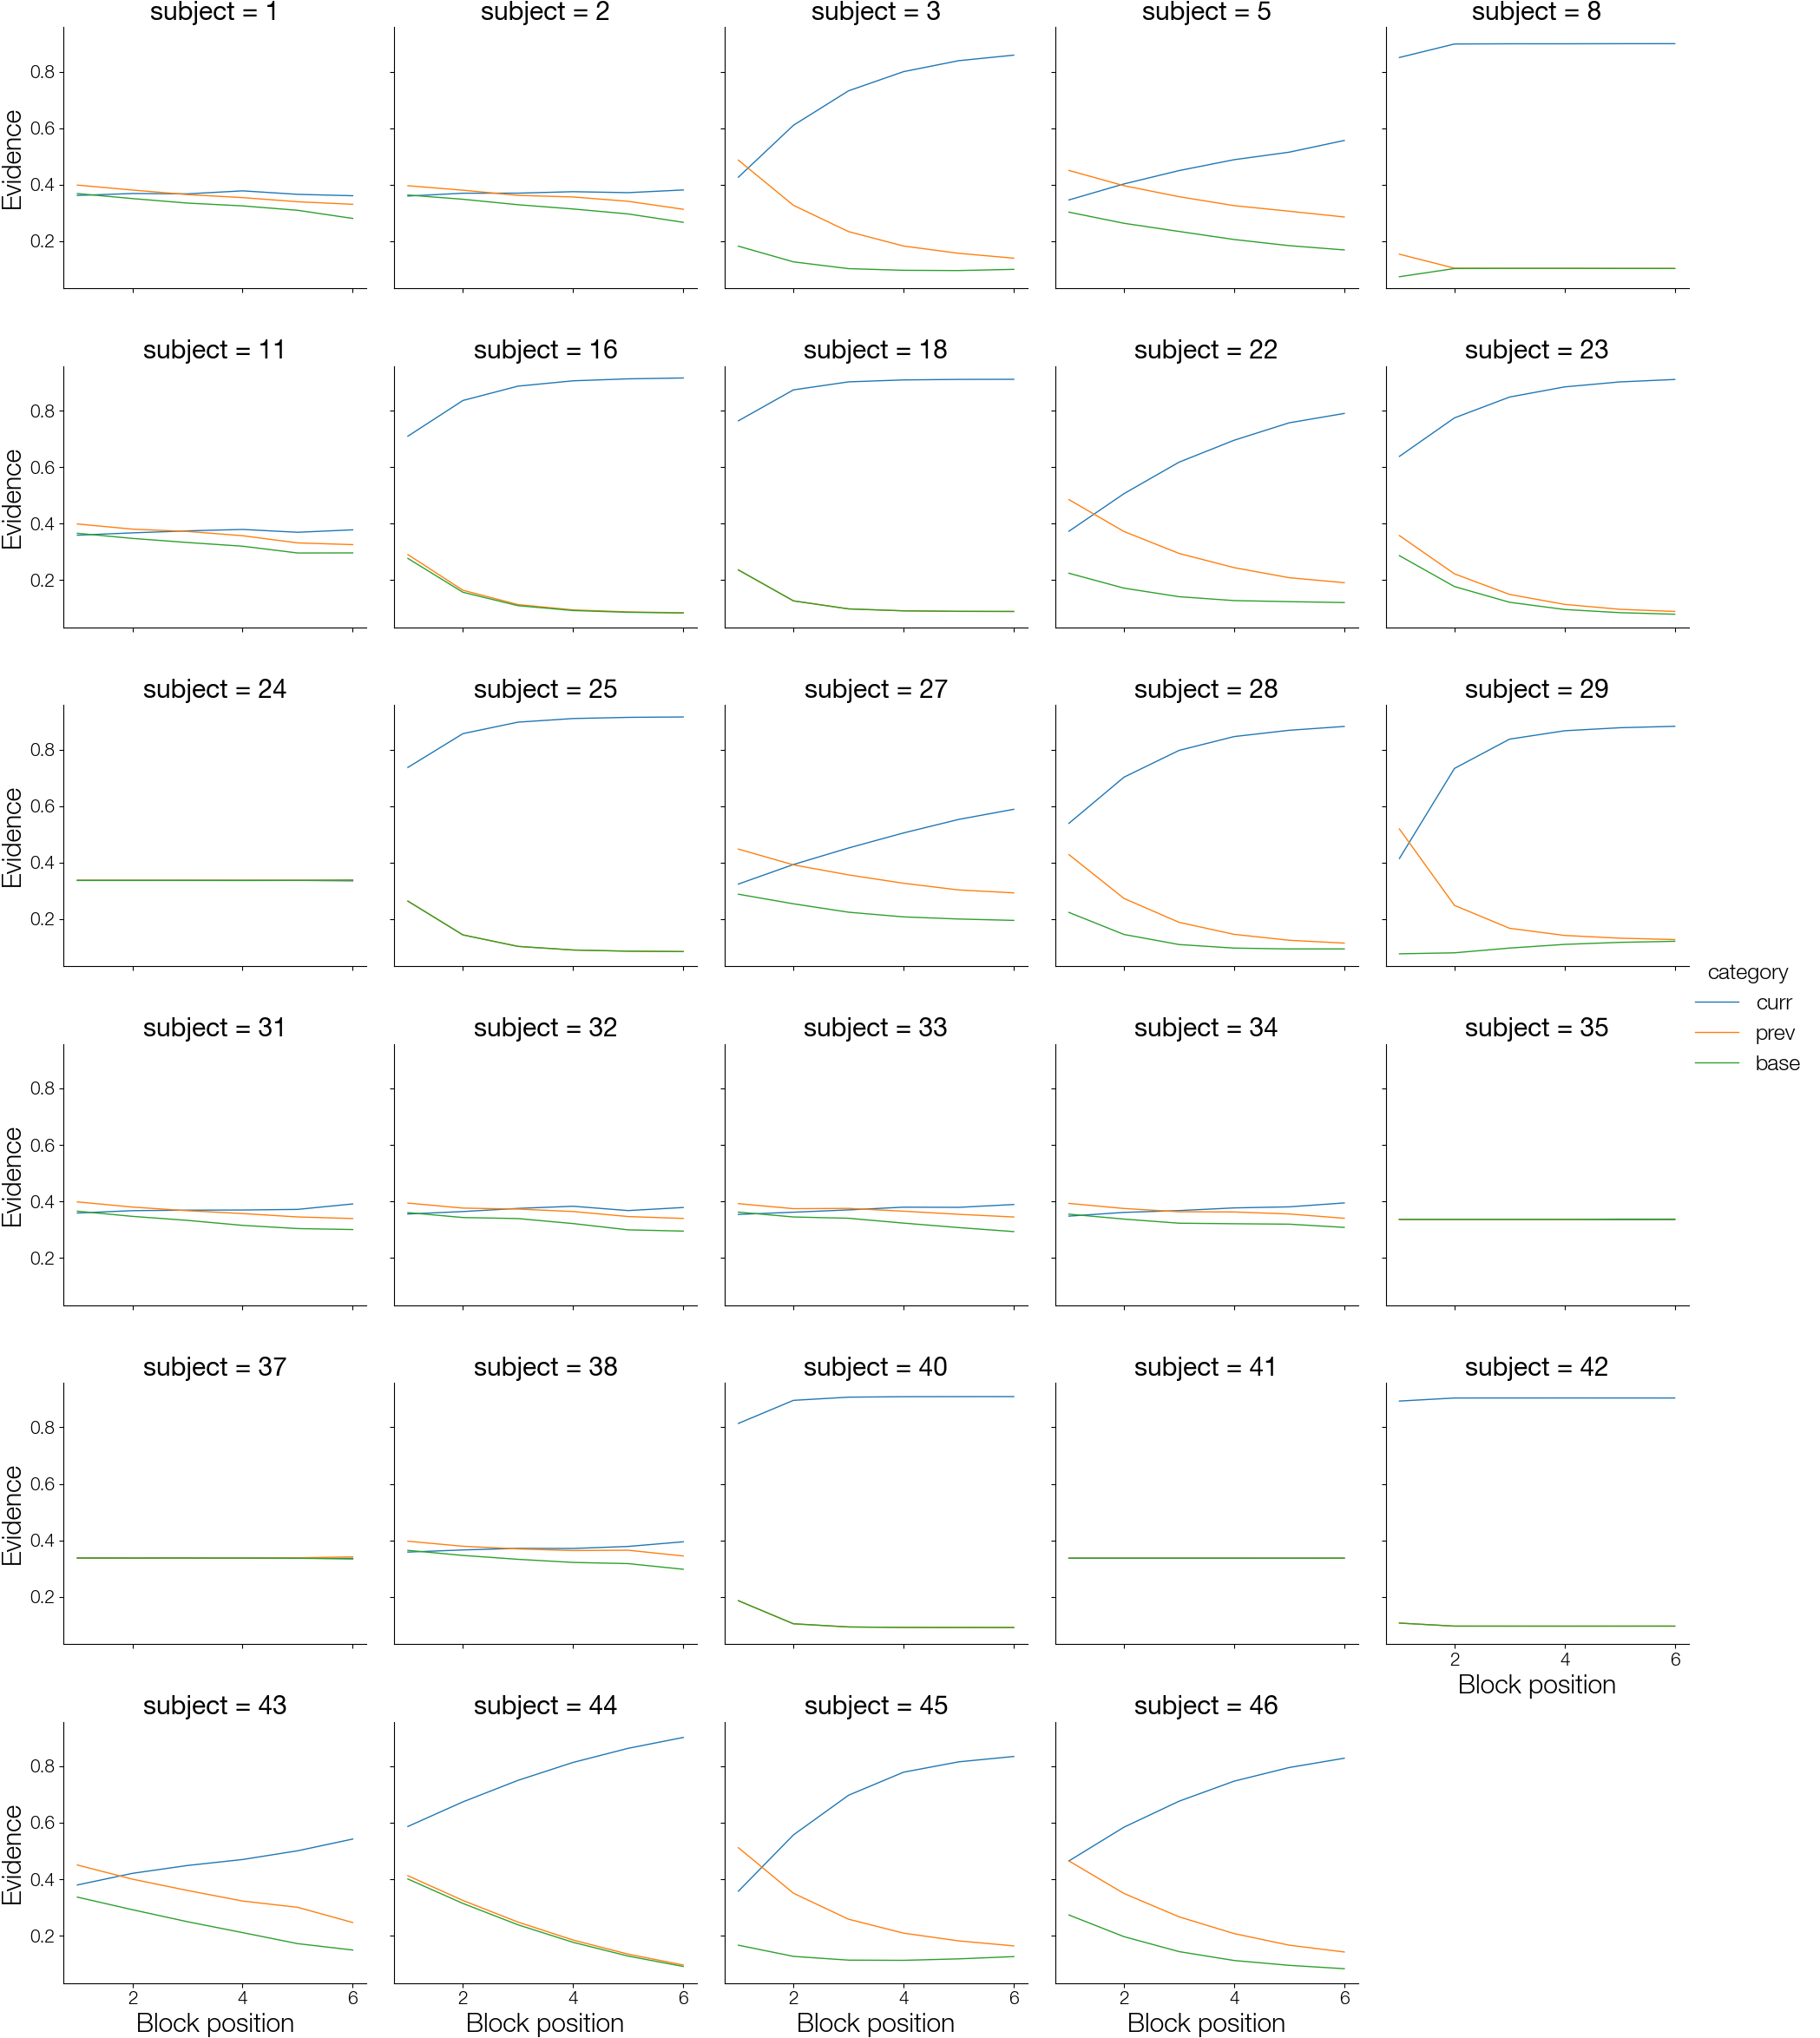

In [7]:
m = decode.evidence_block_pos(evidence)
g = figures.plot_block_pos_evidence(m)

LINO NOT subset; don't know how to subset; dropped


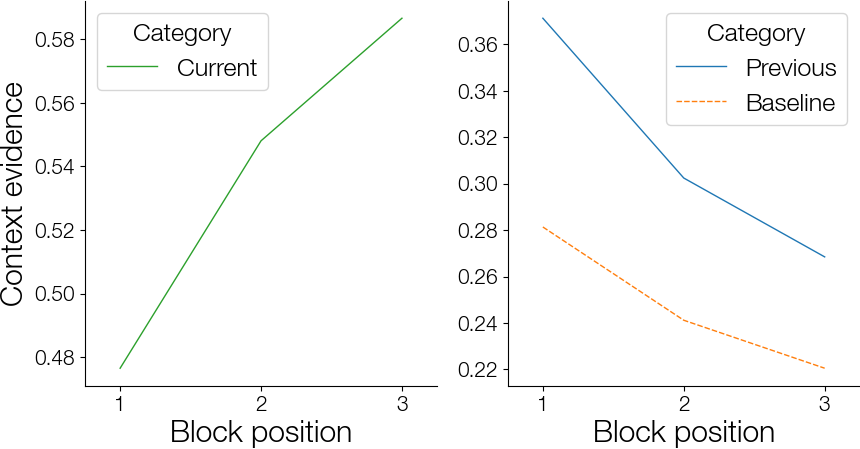

In [8]:
fig, ax = figures.plot_mean_block_pos_evidence(m)
ax[0].set(ylabel=f'{kind_label} evidence')
fig.savefig(fig_dir / f'evidence_block_{kind}.pdf')

## Slope over block position

/Users/morton/PycharmProjects/dcmr/src/dcmr/figures.py:689: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Current', 'Previous', 'Baseline'], fontsize='large')
LINO NOT subset; don't know how to subset; dropped


,curr,prev,base
mean,0.056503,-0.052939,-0.031305
sem,0.011363,0.009346,0.005677


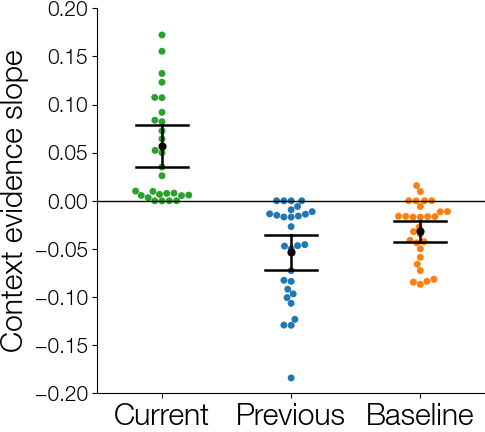

In [9]:
slope = decode.regress_evidence_block_pos(m)
fig, ax = figures.plot_slope_evidence(slope)
ax.set(ylim=(-0.2, 0.2), ylabel=f'{kind_label} evidence slope')
fig.savefig(fig_dir / f'evidence_slope_{kind}.pdf')
slope.agg(['mean', 'sem'])

In [10]:
pg.ttest(slope['curr'], 0, alternative='greater')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.972524,28,greater,0.000015,"[0.04, inf]",0.923375,1561.335,0.99932


In [11]:
pg.ttest(slope['prev'], 0, alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.664385,28,less,0.000002,"[-inf, -0.04]",1.05185,8774.879,0.999947


In [12]:
pg.ttest(slope['base'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.513956,28,two-sided,0.000007,"[-0.04, -0.02]",1.023916,3014.061,0.999606


In [13]:
models = [
    model_name
]
model_names = [
    model_label,
]
param = framework.read_model_fits(fit_dir, models, model_names).droplevel("model")

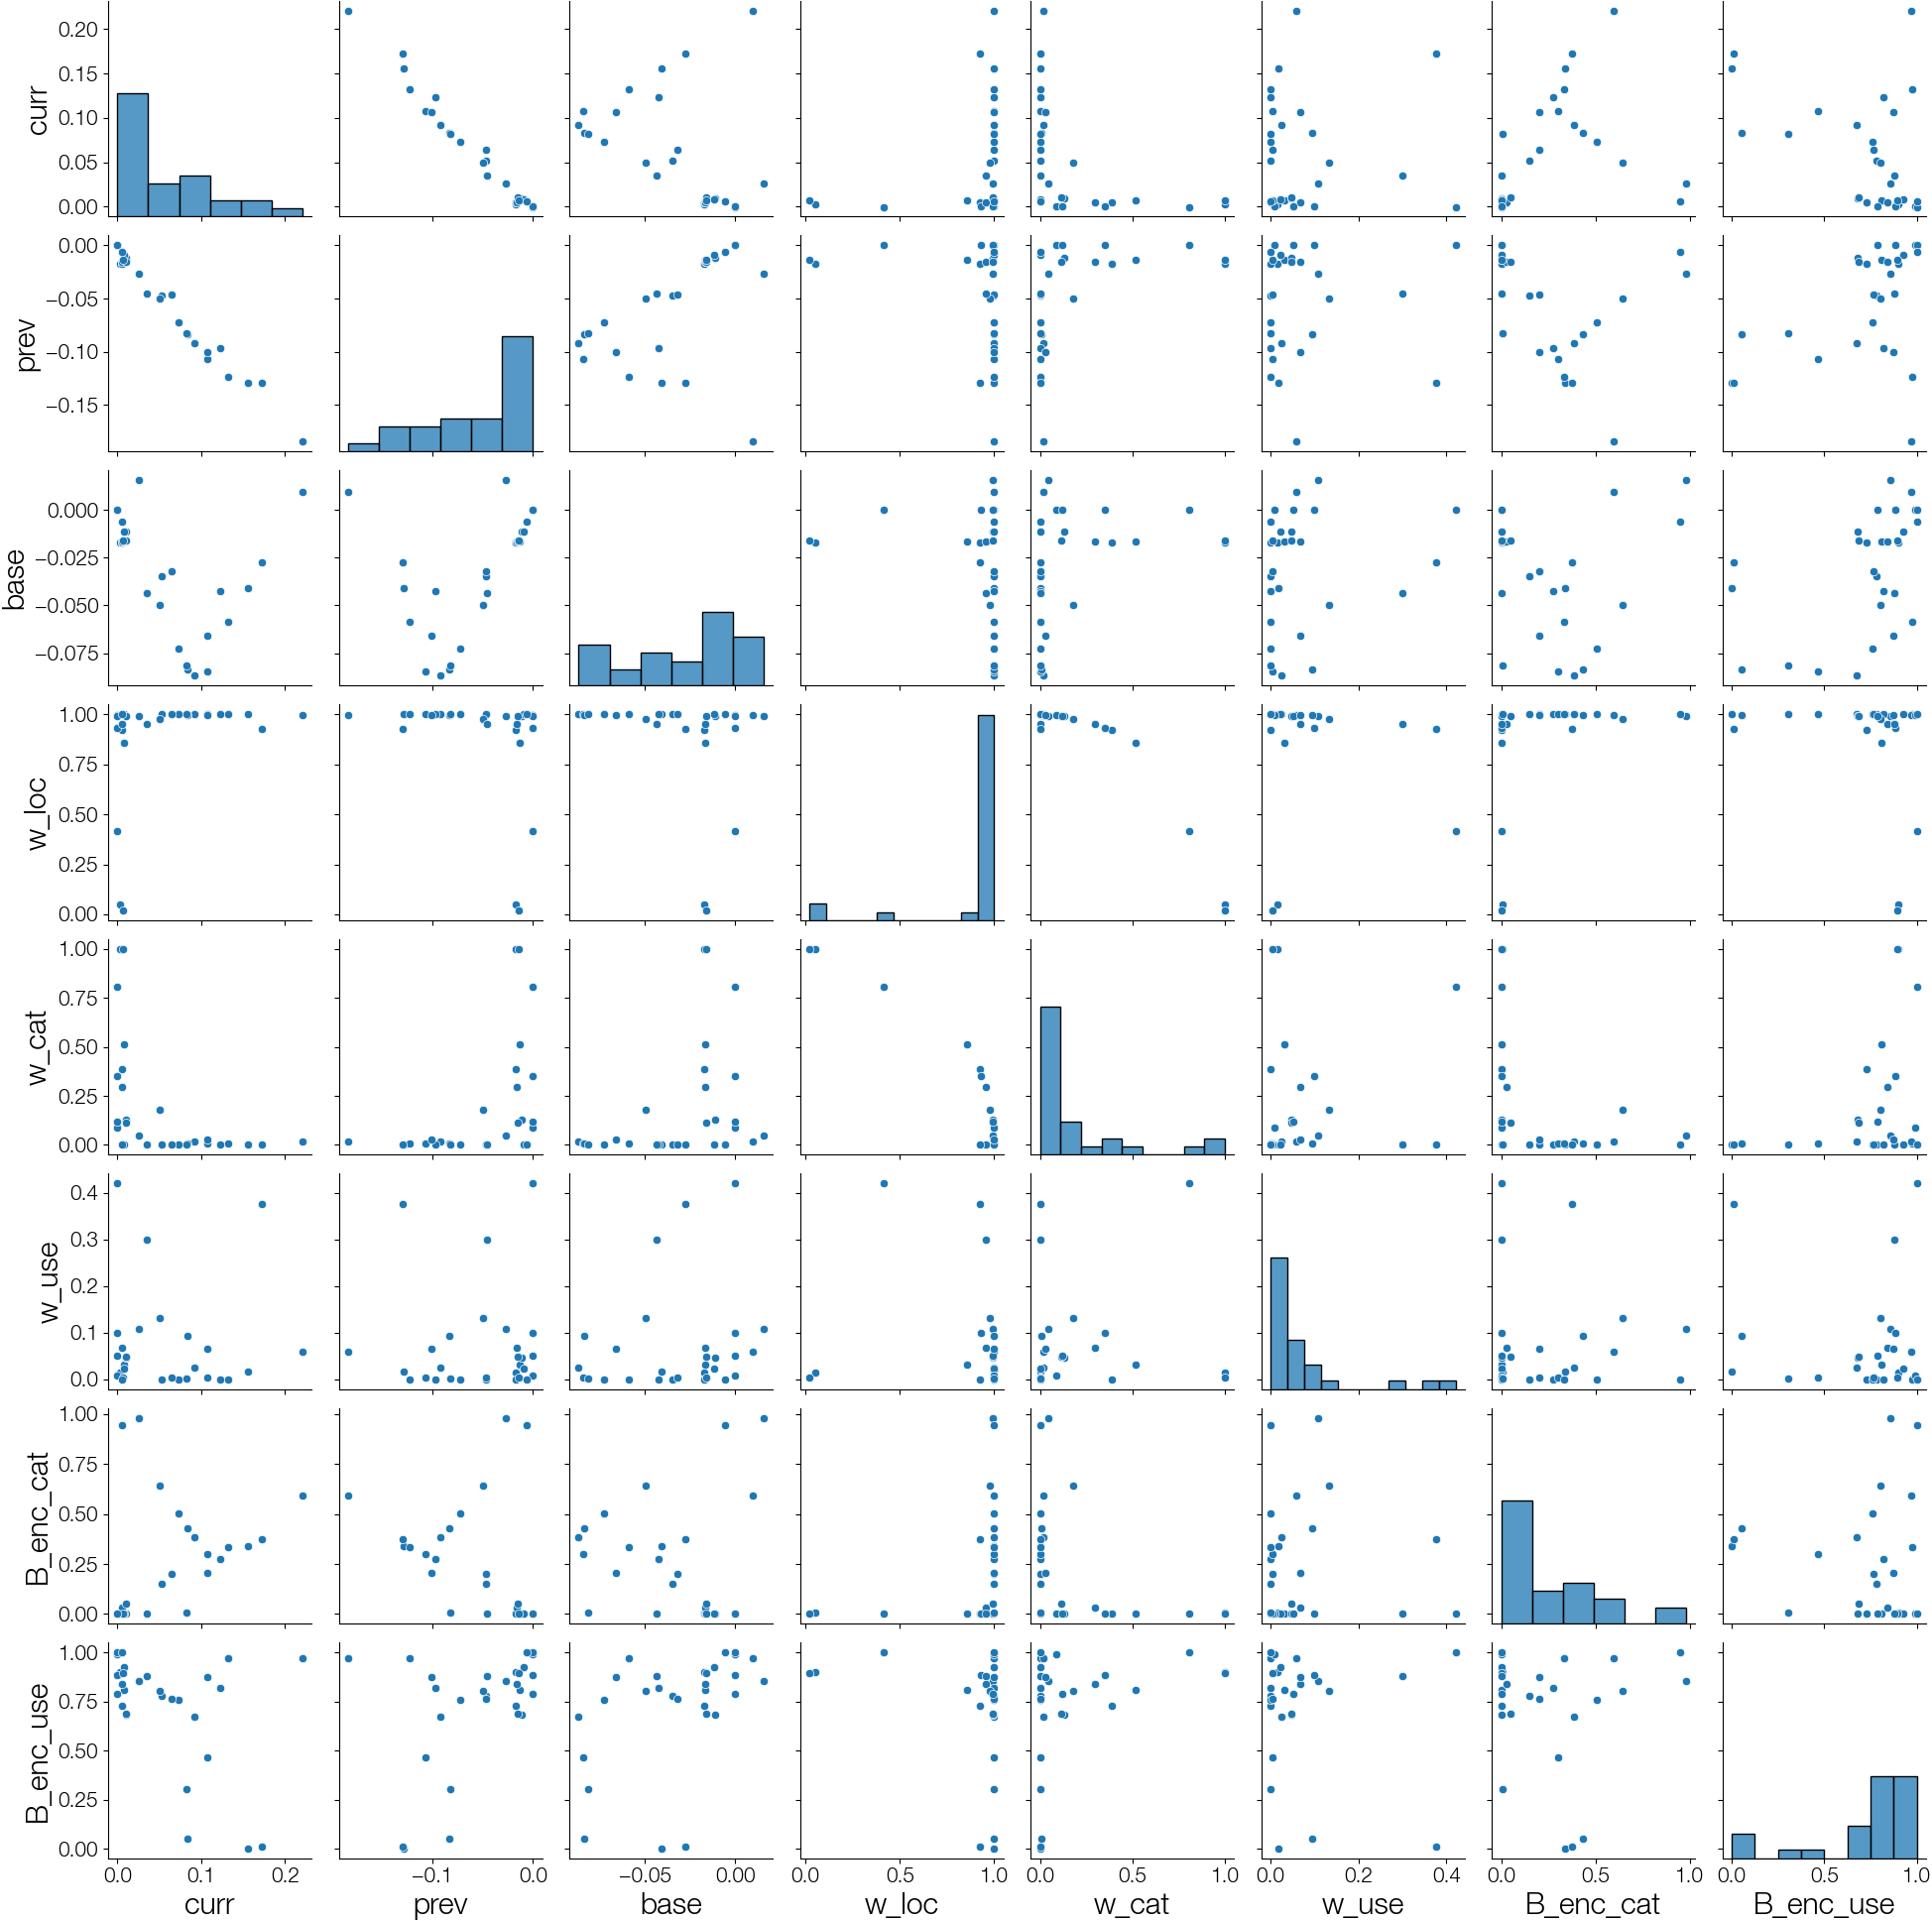

In [14]:
summary = slope.copy()
param_names = ['w_loc', 'w_cat', 'w_use', 'B_enc_cat', 'B_enc_use']
for par in param_names:
    summary[par] = param[par]
sns.pairplot(summary)

In [15]:
slope.to_csv(class_dir / "slope.csv")

In [16]:
temp = fr.lag_rank(
    data.loc[model_label], test_key='category', test=lambda x, y: x == y
).set_index('subject')

In [17]:
clust = fr.category_clustering(
    data.loc[model_label], category_key='category'
).set_index('subject')

In [18]:
cat_crp_remote = fr.category_crp(
    data.loc[model_label], 
    category_key='category', 
    test_key='block', 
    test=lambda x, y: x != y
).set_index('subject')

In [19]:
stats = slope.copy()
stats['temp'] = temp['rank']
stats['lbc'] = clust['lbc']
stats['cat_crp_remote'] = cat_crp_remote['prob']

,n,r,CI95%,p-val,BF10,power
pearson,29,-0.243389,"[-0.52, 1.0]",0.898362,0.109,0.001687


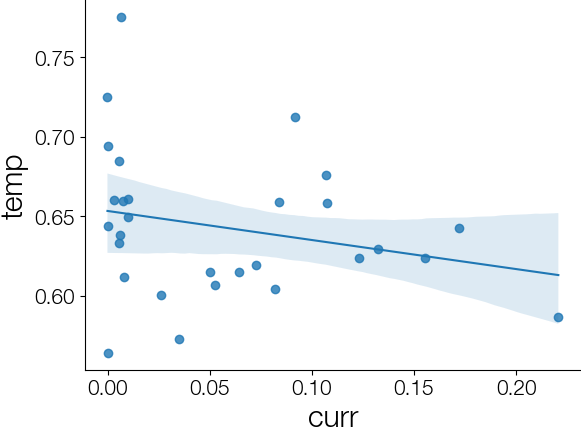

In [20]:
sns.regplot(stats, x="curr", y="temp")
pg.corr(stats["curr"], stats["temp"], method="pearson", alternative='greater')

,n,r,CI95%,p-val,BF10,power
pearson,29,0.116177,"[-0.2, 1.0]",0.274203,0.394,0.149816


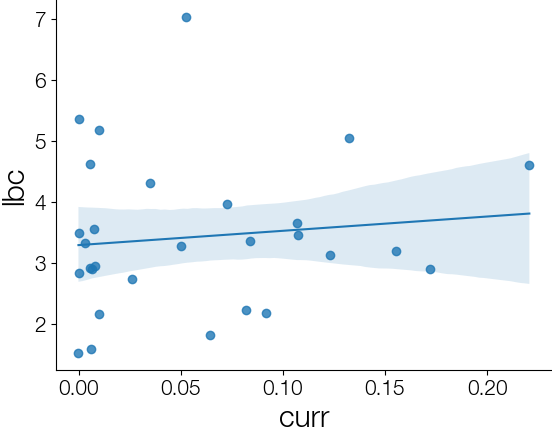

In [21]:
sns.regplot(stats, x="curr", y="lbc")
pg.corr(stats["curr"], stats["lbc"], method="pearson", alternative='greater')

,n,r,CI95%,p-val,BF10,power
pearson,29,0.274983,"[-0.04, 1.0]",0.074412,1.145,0.429104


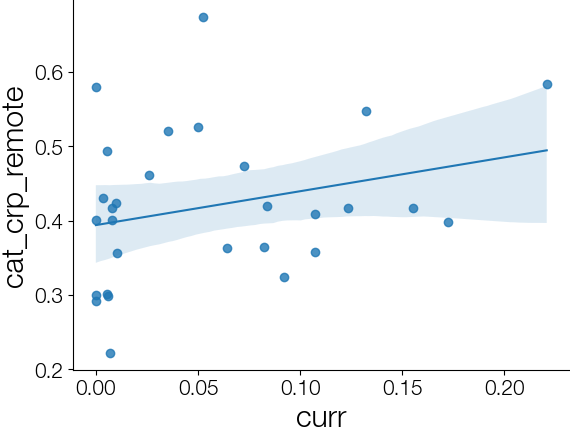

In [22]:
sns.regplot(stats, x="curr", y="cat_crp_remote")
pg.corr(stats["curr"], stats["cat_crp_remote"], method="pearson", alternative='greater')

,n,r,CI95%,p-val,BF10,power
pearson,29,-0.172804,"[-0.46, 1.0]",0.814984,0.131,0.005407


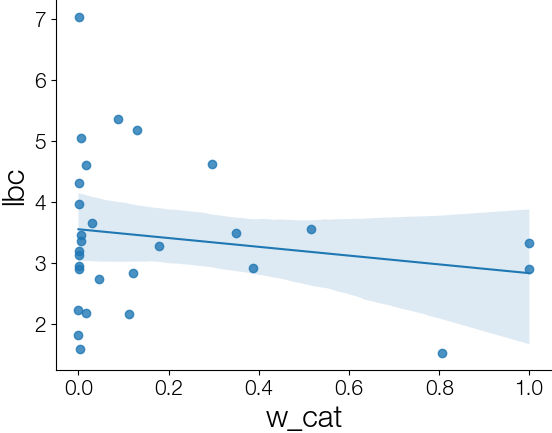

In [23]:
stats['w_cat'] = summary['w_cat']
sns.regplot(stats, x="w_cat", y="lbc")
pg.corr(stats["w_cat"], stats["lbc"], method="pearson", alternative='greater')

In [24]:
eeg_dir = cfr_dir / 'eeg' / 'decode' / 'logreg_pmvpa_r10'
eeg_slope = pd.read_csv(eeg_dir / "slope.csv")

In [25]:
temp_data = fr.lag_rank(
    data.loc['Data'], test_key='category', test=lambda x, y: x == y
).set_index('subject')

In [26]:
clust_data = fr.category_clustering(
    data.loc['Data'], category_key='category'
).set_index('subject')

In [27]:
cat_crp_remote_data = fr.category_crp(
    data.loc['Data'], 
    category_key='category', 
    test_key='block', 
    test=lambda x, y: x != y
)

,n,r,CI95%,p-val,BF10,power
pearson,29,0.013311,"[-0.3, 1.0]",0.472682,0.243,0.057768


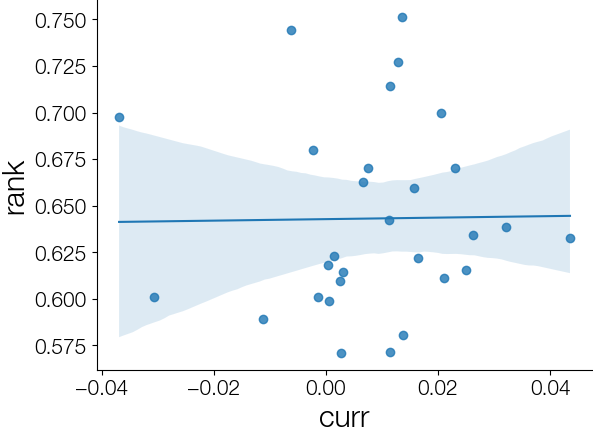

In [28]:
x = eeg_slope['curr']
y = temp_data.reset_index()['rank']
sns.regplot(x=x, y=y)
pg.corr(x, y, method="pearson", alternative='greater')

,n,r,CI95%,p-val,BF10,power
pearson,29,0.346216,"[0.04, 1.0]",0.0329,2.23,0.590991


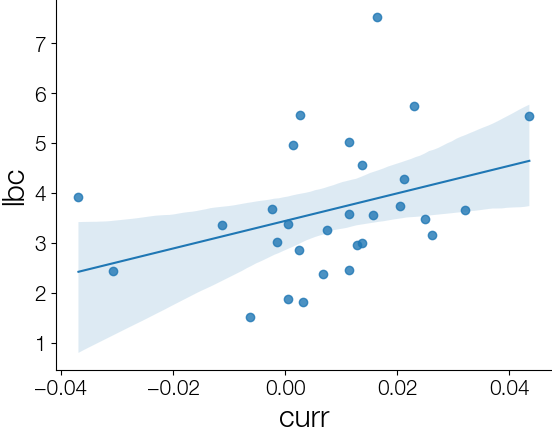

In [29]:
x = eeg_slope['curr']
y = clust_data.reset_index()['lbc']
sns.regplot(x=x, y=y)
pg.corr(x, y, method="pearson", alternative='greater')

,n,r,CI95%,p-val,BF10,power
pearson,29,0.302019,"[-0.01, 1.0]",0.055656,1.45,0.489705


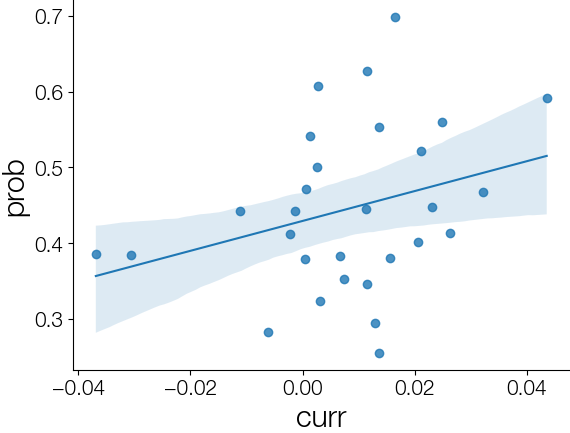

In [30]:
x = eeg_slope['curr']
y = cat_crp_remote_data.reset_index()['prob']
sns.regplot(x=x, y=y)
pg.corr(x, y, method="pearson", alternative='greater')

,n,r,CI95%,p-val,power
spearman,29,-0.035468,"[-0.4, 0.34]",0.855068,0.053339


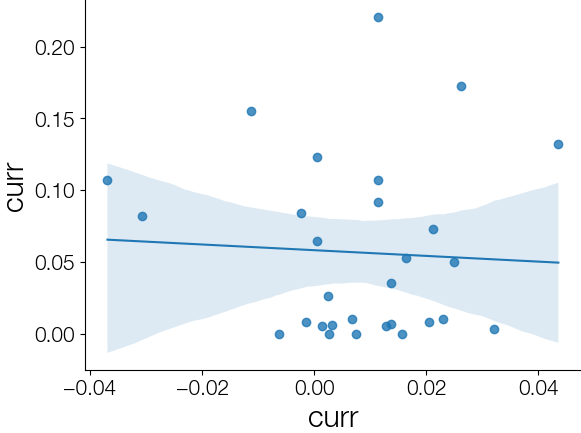

In [31]:
x = eeg_slope["curr"]
y = slope.reset_index()["curr"]
sns.regplot(x=x, y=y)
pg.corr(x, y, method='spearman')

,n,r,CI95%,p-val,power
spearman,29,0.969331,"[0.93, 0.99]",5.476671e-18,1.0


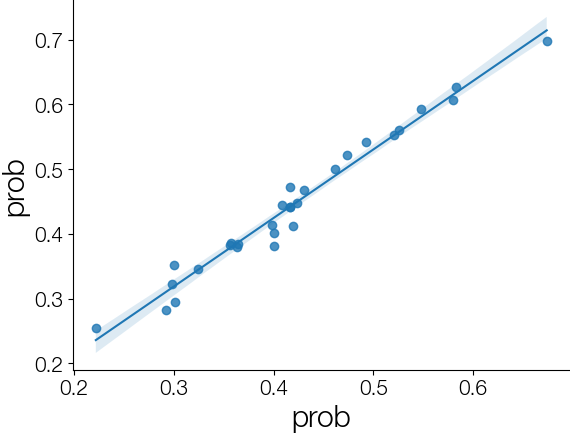

In [32]:
x = cat_crp_remote.reset_index()['prob']
y = cat_crp_remote_data.reset_index()['prob']
sns.regplot(x=x, y=y)
pg.corr(x, y, method='spearman')

,n,r,CI95%,p-val,power
spearman,29,0.924138,"[0.84, 0.96]",8.540776e-13,1.0


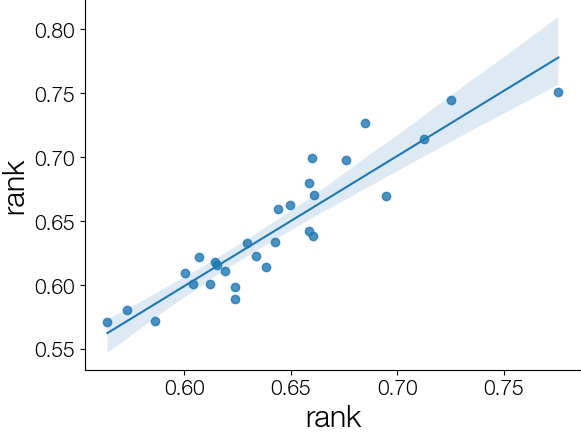

In [33]:
x = temp.reset_index()['rank']
y = temp_data.reset_index()['rank']
sns.regplot(x=x, y=y)
pg.corr(x, y, method='spearman')

In [34]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.9.0

dcmr    : 1.0.0a0
joblib  : 1.5.3
pandas  : 3.0.0
pingouin: 0.5.5
psifr   : 0.10.1
seaborn : 0.13.2

